### RL and Advanced DL: Домашнее задание 1

Первое ДЗ связано с обучением с подкреплением, и оно придумано для ситуации, когда нейронные сети ещё не нужны, и пространство состояний в целом достаточно маленькое, чтобы можно было обучить хорошую стратегию методами TD-обучения или другими методами обучения с подкреплением.

### Часть I

Мы будем обучаться играть в очень простую, но знаменитую и популярную игру: блекджек. 
 
Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:<br>
➢	численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;<br>
➢	туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;<br>
➢	игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;<br>
➢	игрок может совершать одно из двух действий:<br>
○	hit  — взять ещё одну карту;<br>
○	stand — не брать больше карт;<br>
➢	если сумма очков у игрока на руках больше 21, он проигрывает (bust);<br>
➢	если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;<br>
➢	после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);<br>
➢	в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).<br>
Именно этот простейший вариант блекджека реализован в OpenAI Gym:<br>
https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py 
1.	Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.<br>
2.	Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.<br>
3.	Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.<br>


In [243]:
import gym
from gym import envs
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib notebook

In [279]:
np.random.seed(42)

### Simple strategy

In [207]:
from blackjack import BlackjackEnv

In [201]:
# env=gym.make('Blackjack-v1', natural=True)
# or 
# from blackjack import BlackjackEnv
# env = BlackjackEnv(natural=True)

In [209]:
def simple_strategy_episode(env):
    """
    observations:
        score_player, score_dealer, usable_ace [natural blackjack]
    actions: 0 - stand, 1 - hit
    """
    obs, actions, rewards = [], [], []
    observation = env.reset()
    done = False
    while not done:
        score_player, score_dealer, usable_ace = observation
        action = 1 if score_player < 19 else 0
        actions.append(action)
        obs.append(observation)
        observation, reward, done, _ = env.step(action)
        rewards.append(reward)
    return obs, actions, rewards

In [249]:
def plot_mean_reward(reward_history):
    b = np.cumsum(reward_history)
    mean_reward = b/np.arange(1, b.shape[0] + 1)
    plt.figure()
    plt.plot(mean_reward)
    plt.xlabel('episode')
    plt.ylabel('mean reward')
    plt.grid()
    plt.show()
#     return mean_reward[-1]

In [211]:
#Single example
env = BlackjackEnv(natural=True)
obs, actions, rewards = simple_strategy_episode(env)
print(f"observations[score_player, score_dealer, usable_ace]={obs}, actions={actions}, rewards={rewards}" )
env.close()

observations[score_player, score_dealer, usable_ace]=[(19, 2, False)], actions=[0], rewards=[1.0]


In [212]:
env = BlackjackEnv(natural=True)
num_of_episodes = int(1e5)
simple_strategy_reward = 0
reward_history = []
for i in tqdm(range(num_of_episodes)): 
    _, _, rewards = simple_strategy_episode(env)
    simple_strategy_reward = (simple_strategy_reward * i + rewards[-1]) / (i + 1)
    reward_history.append(rewards[-1])
env.close()

In [213]:
print(f"Reward for simple strategy is {simple_strategy_reward}")

Reward for simple strategy is -0.17898500000000073


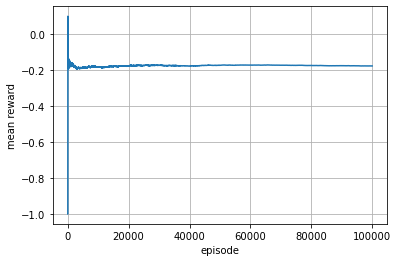

-0.178985

In [214]:
plot_mean_reward(reward_history)

In [215]:
env.close()

#### Reward for simple strategy is~ -0.18

### Q-learning

In [294]:
def get_random_Q():
    """
    Generates random Q in format Q[player_score] = [a.u.reward for hit, a.u.reward for stand]
    """
    
    # численные значения карт равны от 2 до 11 
    # в начале игры у игрока 2 карты, т.е. 4 очка минимум (2+2) и 21 (10+туз) максимум 

    player_Q_Values = {} 
    for player_val in range(4, 33):
        if player_val <= 11: #нет смысла не брать, если счет 11 и ниже
            player_Q_Values[player_val] = np.array([0.0, 1.0])
        elif player_val == 21:
            player_Q_Values[player_val] = np.array([1.0, 0.0]) # stand is 1,  hit is 0 [impossible]                 
        elif player_val > 11 and player_val < 21:
            player_Q_Values[player_val] = np.random.random(2)
        else:
            player_Q_Values[player_val] = np.array([0.0, 0.0])                
    return player_Q_Values

In [217]:
def compute_policy_by_Q(player_Q_Values):
    pi = {}
    for key in player_Q_Values:
        pi[key] = np.argmax( player_Q_Values[key] )
    return pi

In [218]:
def extract_array_from_Q(Q):
    arr = []
    for k in Q.keys():
        arr.append(Q[k])
    arr = np.array(arr)
    return arr

In [219]:
def key_to_idx(Q):
    idx_dict = {}
    idx = 0
    for k in Q.keys():
        idx_dict[k] = idx
        idx += 1
    return idx_dict    

In [298]:
def Q_learning_episode(env, pi, Q, alpha=0.05, epsilon=0.0, gamma=0.9, nA=2, count=False):
    """
    nA - total number of possible actions
    count - defines format of key in Q [if False key=player_score, if True key = (player_score, card_count)]
    """
    states, actions, rewards = [], [], []
    observation = env.reset()
    #observations is [score_player, score_dealer, usable_ace]    
    
    if not count:
        s = observation[0]
    else:
        s = (observation[0], observation[-1])
    
    
    a = pi[s] if np.random.rand() > epsilon else np.random.randint(nA)
    done = False
    
    while not done:
        observation, reward, done, _ = env.step(a)
        states.append(s)
        actions.append(a)
        rewards.append(reward)
        if not count:
            s_prime = observation[0]
        else:
            s_prime = (observation[0], observation[-1])        
        a_prime = pi[s_prime] if np.random.rand() > epsilon else np.random.randint(nA)
        #if s > 11 and s < 21:#без этого условия начинает оптимизировать начальные значения
            Q[s][a] = Q[s][a] + alpha * (reward + gamma * np.max(Q[s_prime]) - Q[s][a])
        s, a = s_prime, a_prime
        
    return  states, actions, rewards    

### Test

In [221]:
env=gym.make('Blackjack-v1', natural=True)

Q = get_random_Q()
pi = compute_policy_by_Q(Q)
idxs = key_to_idx(Q)

Q_hist_Qlearn = [ ]
reward_history = []
Q_hist_Qlearn.append(extract_array_from_Q(Q))

num_of_episodes = int(1e2)
for _ in tqdm(range(num_of_episodes)):
    _, _, rewards = Q_learning_episode(env, pi, Q, nA=2)
    reward_history.append(rewards[-1])
    pi = compute_policy_by_Q(Q)
    Q_hist_Qlearn.append(np.copy(extract_array_from_Q(Q)))
env.close()    

100%|██████████| 100/100 [00:00<00:00, 3331.93it/s]


#### Подбор гиперпараметров 

In [224]:
eps_range = [0.01, 0.05, 0.1]
alpha_range = [0.0001, 0.001, 0.01]
gamma_range = [0.1, 0.2, 0.4, 0.6]

In [225]:
env=gym.make('Blackjack-v1', natural=True)

reward_history = []
num_of_episodes = int(1e5)

current_run = 1
for epsilon in tqdm(eps_range):
    for alpha in alpha_range:
        for gamma in gamma_range:
            Q = get_random_Q()
            pi = compute_policy_by_Q(Q)
            episode_reward = 0
            for i in range(num_of_episodes):
                _, _, rewards = Q_learning_episode(env, pi, Q, alpha=alpha, epsilon=epsilon, gamma=gamma, nA=2)
                pi = compute_policy_by_Q(Q)
                episode_reward = (episode_reward * i + rewards[-1]) / (i + 1)
            reward_history.append((epsilon, alpha, gamma, episode_reward))
            print(f"{current_run}: epsilon={epsilon}, alpha={alpha}, gamma={gamma}: avg_reward={episode_reward}")
            current_run += 1
env.close()

  0%|          | 0/3 [00:00<?, ?it/s]

1: epsilon=0.01, alpha=0.0001, gamma=0.1: avg_reward=-0.21961999999999965
2: epsilon=0.01, alpha=0.0001, gamma=0.2: avg_reward=-0.13157000000000113
3: epsilon=0.01, alpha=0.0001, gamma=0.4: avg_reward=-0.09340000000000087
4: epsilon=0.01, alpha=0.0001, gamma=0.6: avg_reward=-0.11132000000000024
5: epsilon=0.01, alpha=0.001, gamma=0.1: avg_reward=-0.09185
6: epsilon=0.01, alpha=0.001, gamma=0.2: avg_reward=-0.09113999999999996
7: epsilon=0.01, alpha=0.001, gamma=0.4: avg_reward=-0.09051000000000096
8: epsilon=0.01, alpha=0.001, gamma=0.6: avg_reward=-0.10464000000000004
9: epsilon=0.01, alpha=0.01, gamma=0.1: avg_reward=-0.08353000000000037
10: epsilon=0.01, alpha=0.01, gamma=0.2: avg_reward=-0.07984000000000016
11: epsilon=0.01, alpha=0.01, gamma=0.4: avg_reward=-0.09984000000000086


 33%|███▎      | 1/3 [04:23<08:47, 263.89s/it]

12: epsilon=0.01, alpha=0.01, gamma=0.6: avg_reward=-0.10620999999999939
13: epsilon=0.05, alpha=0.0001, gamma=0.1: avg_reward=-0.16359999999999883
14: epsilon=0.05, alpha=0.0001, gamma=0.2: avg_reward=-0.19416999999999862
15: epsilon=0.05, alpha=0.0001, gamma=0.4: avg_reward=-0.18735999999999858
16: epsilon=0.05, alpha=0.0001, gamma=0.6: avg_reward=-0.1998999999999975
17: epsilon=0.05, alpha=0.001, gamma=0.1: avg_reward=-0.09841000000000026
18: epsilon=0.05, alpha=0.001, gamma=0.2: avg_reward=-0.10423000000000021
19: epsilon=0.05, alpha=0.001, gamma=0.4: avg_reward=-0.1068499999999992
20: epsilon=0.05, alpha=0.001, gamma=0.6: avg_reward=-0.12310000000000024
21: epsilon=0.05, alpha=0.01, gamma=0.1: avg_reward=-0.0954499999999996
22: epsilon=0.05, alpha=0.01, gamma=0.2: avg_reward=-0.09882999999999931
23: epsilon=0.05, alpha=0.01, gamma=0.4: avg_reward=-0.11630999999999986


 67%|██████▋   | 2/3 [08:56<04:28, 268.83s/it]

24: epsilon=0.05, alpha=0.01, gamma=0.6: avg_reward=-0.12660000000000102
25: epsilon=0.1, alpha=0.0001, gamma=0.1: avg_reward=-0.14598000000000078
26: epsilon=0.1, alpha=0.0001, gamma=0.2: avg_reward=-0.18170000000000008
27: epsilon=0.1, alpha=0.0001, gamma=0.4: avg_reward=-0.1720099999999989
28: epsilon=0.1, alpha=0.0001, gamma=0.6: avg_reward=-0.14997999999999828
29: epsilon=0.1, alpha=0.001, gamma=0.1: avg_reward=-0.11442000000000015
30: epsilon=0.1, alpha=0.001, gamma=0.2: avg_reward=-0.11812000000000064
31: epsilon=0.1, alpha=0.001, gamma=0.4: avg_reward=-0.12912000000000043
32: epsilon=0.1, alpha=0.001, gamma=0.6: avg_reward=-0.13621999999999912
33: epsilon=0.1, alpha=0.01, gamma=0.1: avg_reward=-0.11177999999999992
34: epsilon=0.1, alpha=0.01, gamma=0.2: avg_reward=-0.12126000000000003
35: epsilon=0.1, alpha=0.01, gamma=0.4: avg_reward=-0.13615999999999912


100%|██████████| 3/3 [13:27<00:00, 269.30s/it]

36: epsilon=0.1, alpha=0.01, gamma=0.6: avg_reward=-0.14211999999999403


In [330]:
fin_history = np.array([np.array(item) for item in reward_history])
with open("qlearn_parameter_search_v1.txt", 'w') as f:
    for item in fin_history:
        f.write("%s\n" % item)

In [331]:
print(f"Optimal parameters are {fin_history[fin_history[:, 3].argmax()]}")

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

#### Оптимальные параметры получились: epsilon=0.01, alpha=0.01, gamma=0.2

In [310]:
# env=gym.make('Blackjack-v1', natural=True)
env = BlackjackEnv(natural=True)

reward_history_v1 = []

Q1 = get_random_Q()
pi = compute_policy_by_Q(Q1)

num_of_episodes = int(1e5)
for _ in tqdm(range(num_of_episodes)):
    _, _, rewards = Q_learning_episode(env, pi, Q1, epsilon=0.01, alpha=0.01, gamma=0.2)
    reward_history_v1.append(rewards[-1])
    pi = compute_policy_by_Q(Q1)
    
env.close()

100%|██████████| 100000/100000 [00:14<00:00, 6973.50it/s]


<IPython.core.display.Javascript object>


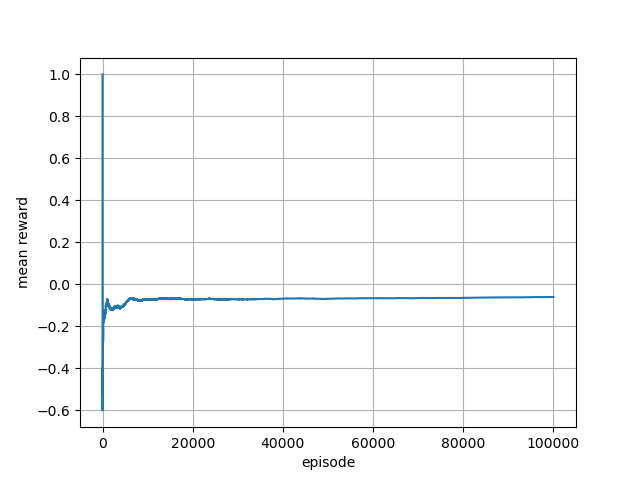

In [302]:
plot_mean_reward(reward_history_v1)

In [303]:
print(f"Reward for q learning is {np.mean(reward_history_v1)}")

Reward for q learning is -0.05988


In [304]:
env.close()

### Часть II

В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:<br>
➢	double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.<br>
4.	Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.<br>
5.	Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.<br>

In [131]:
from blackjack import BlackjackDoubleEnv

In [305]:
def get_random_Q_double():
    
    # добавляем в Q награды за третье действие double

    player_Q_Values = {} 
    for player_val in range(4, 33):
        if player_val <= 11: #нет смысла не брать, если счет 11 и ниже
            player_Q_Values[player_val] = np.array([0.0, 1.0, np.random.random()]) 
        elif player_val == 21:
            player_Q_Values[player_val] = np.array([1.0, 0.0, 0.0])#stand is 1, hit is 0 [impossible], double 0 [impossible]                   
        elif player_val > 11 and player_val < 21:
            player_Q_Values[player_val] = np.random.random(3)
        else:
            player_Q_Values[player_val] = np.array([0.0, 0.0, 0.0])              
    return player_Q_Values

In [307]:
env = BlackjackDoubleEnv(natural=True)
reward_history_v2 = []

Q2 = get_random_Q_double()
pi = compute_policy_by_Q(Q2)

num_of_episodes = int(1e5)
for _ in tqdm(range(num_of_episodes)):
    _, _, rewards = Q_learning_episode(env, pi, Q2, epsilon=0.01, alpha=0.01, gamma=0.2, nA=3)
    reward_history_v2.append(rewards[-1])
    pi = compute_policy_by_Q(Q2)
    
env.close()

100%|██████████| 100000/100000 [00:14<00:00, 6858.24it/s]


<IPython.core.display.Javascript object>


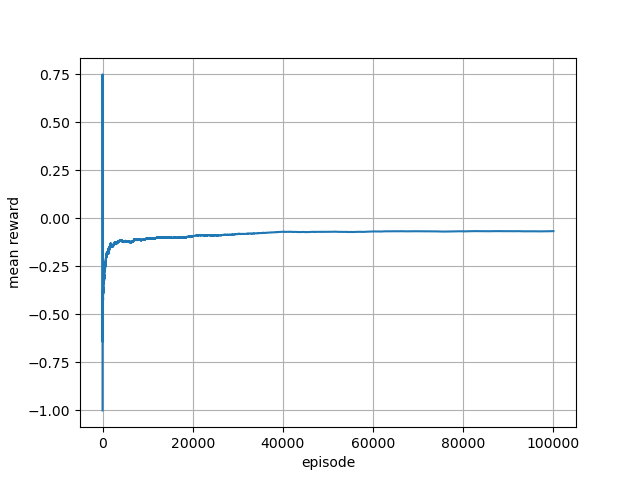

In [308]:
plot_mean_reward(reward_history_v2)

In [309]:
print(f"Reward for q learning with doubling is {np.mean(reward_history_v2)}")

Reward for q learning with doubling is -0.0663


In [237]:
env.close()

### Часть III

А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.<br>

Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.<br>
6.	Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).<br>
7.	Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.<br>

In [139]:
from blackjack import BlackjackCountDoubleEnv

В BlackjackCountDoubleEnv реализован метод посчета карт "половинки"
https://ru.wikipedia.org/wiki/%D0%91%D0%BB%D1%8D%D0%BA%D0%B4%D0%B6%D0%B5%D0%BA

In [311]:
def get_random_Q_count():
    
    # добавляем в Q ключи, зависящие от текущего счета

    player_Q_Values = {} 
    for player_val in range(4, 33):
        for count in np.arange(-17, 15.5, 0.5):
        # вроде при таком подсчете самое минимальное, 
        # что можно насчитать до перемешивания колоды, это -17 
        # (если сумма полной колоды 0, остались для перемешивания 15 карт, 
        # из которых 4 карты веса 1.5 и 11 веса 1) 
        # а максимальное - это 15 (выкинули 15 карт веса -1)
            if player_val <= 11: #нет смысла не брать, если счет 11 и ниже
                player_Q_Values[(player_val, count)] = np.array([0.0, 1.0, np.random.random()])
            elif player_val == 21:
                player_Q_Values[(player_val, count)] = np.array([1.0, 0.0, 0.0]) #stand is 1, hit is 0 [impossible], double 0 [impossible]                   
            elif player_val > 11 and player_val < 21:
                player_Q_Values[(player_val, count)] = np.random.random(3)
            else:
                player_Q_Values[(player_val, count)] = np.array([0.0, 0.0, 0.0])                
    return player_Q_Values

In [312]:
env = BlackjackCountDoubleEnv(natural=True)
reward_history_v3 = []

Q3 = get_random_Q_count()
pi = compute_policy_by_Q(Q3)

num_of_episodes = int(1e5)
for i in tqdm(range(num_of_episodes)):
    _, _, rewards = Q_learning_episode(env, pi, Q3, epsilon=0.01, alpha=0.01, gamma=0.2, nA=3, count=True)
    reward_history_v3.append(rewards[-1])
    pi = compute_policy_by_Q(Q3)
env.close()

100%|██████████| 100000/100000 [07:57<00:00, 209.25it/s]


<IPython.core.display.Javascript object>


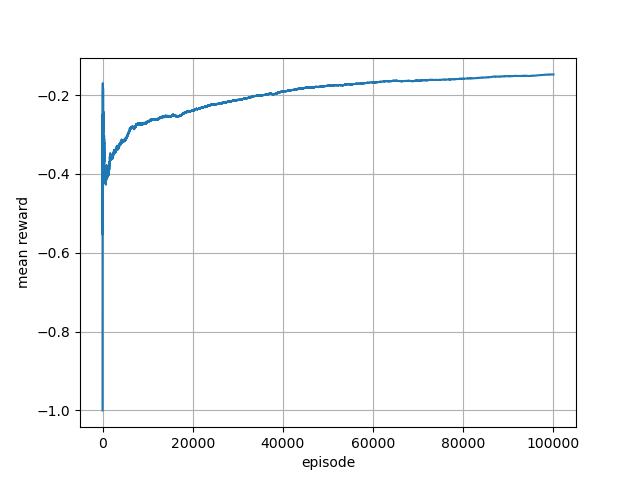

In [313]:
plot_mean_reward(reward_history_v3)

In [314]:
print(f"Reward for q learning with doubling is {np.mean(reward_history_v3)}")

Reward for q learning with doubling is -0.147605


In [109]:
with open("reward_hist_v3.txt", 'w') as f:
    for item in reward_history_v3:
        f.write("%s\n" % item)    

In [ ]:
env.close()

In [326]:
a = -10000

In [327]:
np.mean(reward_history_v1[a:])

-0.0786

In [328]:
np.mean(reward_history_v2[a:])

-0.06225

In [329]:
np.mean(reward_history_v3[a:])

-0.108

### Итого: 
1) в среднем простая стратегия дает выигрыш -0.178985 <br>
2) q-обучение с подобранными гиперпараметрами (epsilon=0.01, alpha=0.01, gamma=0.2) дало -0.05988 <br>
3) q-обучение с опцией удвоения ставки: -0.0663 <br>
4) q-обучение с удвоением ставки и подсчетом карт по методу "половинки": -0.147605 <br>

Обыграть казино не удалось. 
Стратегии, полученные с Q-обучением оказались лучше базовой. Варианты 3-4 подозрительно не дали улучшения по сравнению с вариантом 2. Возможно, на них нужно больше эпизодов, либо еще лучше подобрать гиперпараметры.

In [315]:
Q1

{4: array([-0.04816037, -0.0363013 ]),
 5: array([-0.07353028, -0.05432371]),
 6: array([-0.0961822 , -0.06320446]),
 7: array([-0.11324412, -0.05560463]),
 8: array([-0.07583654, -0.02917497]),
 9: array([-0.08353302,  0.00037999]),
 10: array([-0.06220719,  0.02163134]),
 11: array([-0.09457856,  0.06409978]),
 12: array([-0.4367632 , -0.31535386]),
 13: array([-0.58579926, -0.34219018]),
 14: array([-0.6017673 , -0.43086188]),
 15: array([-0.49114862, -0.55162227]),
 16: array([-0.61713127, -0.56667506]),
 17: array([-0.37141426, -0.62037106]),
 18: array([ 0.02341713, -0.4183945 ]),
 19: array([ 0.38741534, -0.28644028]),
 20: array([ 0.66544575, -0.23795397]),
 21: array([ 1.31355284, -0.2080302 ]),
 22: array([0., 0.]),
 23: array([0., 0.]),
 24: array([0., 0.]),
 25: array([0., 0.]),
 26: array([0., 0.]),
 27: array([0., 0.]),
 28: array([0., 0.]),
 29: array([0., 0.]),
 30: array([0., 0.]),
 31: array([0., 0.]),
 32: array([0., 0.])}

In [316]:
Q2

{4: array([-0.04609852, -0.03974225, -0.05226944]),
 5: array([-0.07674914, -0.05416837, -0.10775897]),
 6: array([-0.08616894, -0.06150659, -0.10278173]),
 7: array([-0.08441563, -0.0462438 , -0.15442677]),
 8: array([-0.09479048, -0.02714221, -0.0459137 ]),
 9: array([-0.08024724,  0.00017595, -0.02545881]),
 10: array([-0.03276707,  0.0345398 , -0.0687568 ]),
 11: array([-0.03388608,  0.06947169, -0.06504494]),
 12: array([-0.42261202, -0.35657861, -0.44092093]),
 13: array([-0.47023313, -0.31912941, -0.46848183]),
 14: array([-0.52071192, -0.33624194, -0.54908586]),
 15: array([-0.52859162, -0.46624616, -0.65351136]),
 16: array([-0.61041019, -0.5238932 , -0.64982166]),
 17: array([-0.21731041, -0.60213447, -0.56749858]),
 18: array([ 0.04739872, -0.32082502, -0.40834673]),
 19: array([ 0.42725842, -0.06976992, -0.17648   ]),
 20: array([ 0.81967745, -0.21264332, -0.20077296]),
 21: array([ 1.32518095, -0.1850465 , -0.09496811]),
 22: array([0., 0., 0.]),
 23: array([0., 0., 0.]),


In [317]:
Q3

{(4, -17.0): array([0.        , 1.        , 0.85568771]),
 (4, -16.5): array([0.        , 1.        , 0.85561393]),
 (4, -16.0): array([0.        , 1.        , 0.52141777]),
 (4, -15.5): array([0.        , 1.        , 0.09586423]),
 (4, -15.0): array([0.        , 1.        , 0.73486845]),
 (4, -14.5): array([0.        , 1.        , 0.52477885]),
 (4, -14.0): array([0.      , 1.      , 0.269411]),
 (4, -13.5): array([0.        , 1.        , 0.82777502]),
 (4, -13.0): array([0.        , 1.        , 0.34348502]),
 (4, -12.5): array([0.        , 1.        , 0.65763939]),
 (4, -12.0): array([0.        , 1.        , 0.11554402]),
 (4, -11.5): array([0.        , 1.        , 0.81015118]),
 (4, -11.0): array([0.        , 1.        , 0.29954355]),
 (4, -10.5): array([0.        , 1.        , 0.62987933]),
 (4, -10.0): array([0.        , 0.99198303, 0.11510777]),
 (4, -9.5): array([0.        , 0.99196777, 0.42462006]),
 (4, -9.0): array([0.        , 1.        , 0.88934575]),
 (4, -8.5): array([0. 